<a href="https://colab.research.google.com/github/flaviovdf/musica/blob/main/notebooks/lab08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Descomente e rode para usar no colab
! pip install git+https://github.com/flaviovdf/musica.git

  Cloning https://github.com/flaviovdf/musica.git to /tmp/pip-req-build-tj3ear1h
  Running command git clone -q https://github.com/flaviovdf/musica.git /tmp/pip-req-build-tj3ear1h


# Decomposição de Matrizes Musicais

**Objetivos**
1. Revisar Decomposição de Matrizes
1. Revisar SVD
1. Aprender um pouco sobre NMF

**Resultado Esperado**
1. Saber fazer uso do SKLearn para separar instrumentos

In [48]:
from μsica import μsf
from μsica import μsp

from numba import jit

import jax.numpy as jnp
import jax

import librosa
import librosa.display

import IPython.display as ipd

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [ ]:
μsp.init_matplotlib()
plt.ion()

## Introdução

Como vimos em sala de aula, a tarefa de separação de fontes (*source separation*) serve para extrair diferentes padrões de aúdio que se repetem em uma música. Aqui, um padrão pode ser visto como informação redundante na matriz do espectrograma de tempo curto. Como tal padrão se repete, a separação de fontes visa capturar os diferentes instrumentos tocados na música.

## Decomposição em Valores Singulares

Em álgebra linear, a decomposição em valores singulares ou singular value decomposition (SVD) é a fatoração de uma matriz real ou complexa, com diversas aplicações importantes em processamento de sinais e estatística.

Formalmente, a decomposição em valores singulares de uma matriz m×n real ou complexa X é uma fatoração ou fatorização na forma: 

$$ X = U \Sigma V^{*} $$ 

Aqui, $U$ é a matriz de vetores singulares à direita. $\Sigma$ é uma matriz diagonal com os valores singulares. Por fim, $V^{*}$ é a transposta conjugada dos valores singulares à direita. *Possivelmente você deve estar pensando: "massa, um monte de termo que sei muito pouco sobre"*. Se este é o seu caso, não se preocupe! Vamos tentar focar em uma ideia mais simples de SVD.

Para tal, uma outra forma de escrever tal equação é:

$$ X = U_s V^{t} $$ 

onde, $U_s = U \Sigma$, ou seja, o produto da primeira parte da equação acima. Aqui, $V^{t}$ é simplesmente transposta de $V$. Não vamos nos preocupar com transpostas conjugadas pois vamos trabalhar com números reais.

Em sua forma correta, $ X = U \Sigma V^{*} $, SVD consegue decompor qualquer matriz, $X$, real ou complexa. A decomposição também vai ser complexa, isto é, $U$, $\Sigma$ e $V$ podem conter números complexos. É importante ressaltar este fato para deixar claro que SVD consegue trabalhar no espectrograma complexo caso seja necessário. Fazemos uso da versão modificada aqui, pois conseguimos visualizar o espectro usando a norma dos números complexos, ou seja, um valor real.

Antes de começar vamos olhar para o espectrograma de um pequeno trecho musical.

In [7]:
μsf.download('http://dcc.ufmg.br/~flaviovdf/mir/examples/drum.wav', 'drum.wav',
             False)

drum.wav: 331kB [09:46, 577B/s]


In [15]:
wav, sr = librosa.load('drum.wav')
ipd.Audio(wav, rate=sr)

Observe como o espectrograma é uma matriz de valores complexas

In [18]:
S = librosa.stft(wav)
S[0, 0]

(-20.429443+0j)

In [19]:
S.real

array([[-2.04294434e+01, -9.60280991e+00,  8.57357323e-01, ...,
         2.86548818e-03,  2.77445111e-02,  1.50528997e-01],
       [ 2.10104923e+01, -1.22868609e+00, -5.03100574e-01, ...,
        -2.04157755e-02,  7.20952218e-03, -6.23248741e-02],
       [-2.65991325e+01,  1.11167183e+01,  2.21814632e+00, ...,
         1.98108591e-02,  2.22539827e-02, -1.32204458e-01],
       ...,
       [-1.06431765e-03,  6.45676104e-04,  5.56440573e-05, ...,
         2.59905064e-05,  3.07723647e-04, -2.18525412e-03],
       [ 9.81305144e-04, -3.17966886e-04, -2.34028790e-04, ...,
        -1.96095876e-04, -1.19744625e-04, -1.15760497e-03],
       [-6.83862483e-04,  5.79404514e-05,  3.53292795e-04, ...,
         3.19004641e-04,  5.40562265e-04,  3.09617771e-03]], dtype=float32)

In [20]:
S.imag

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-2.9039271e-15,  1.0714315e+01, -2.4061909e-01, ...,
        -5.8182417e-03,  1.4468883e-02,  1.1686841e-01],
       [-4.6189223e-15,  3.4777143e+00, -4.1857952e-01, ...,
         3.1232927e-02, -3.4713306e-02, -9.1028683e-02],
       ...,
       [ 1.7803019e-16,  3.2414848e-04, -2.9644073e-04, ...,
        -1.3354661e-04, -3.1610118e-05,  2.0205786e-03],
       [ 5.1694760e-16, -6.9710822e-04,  3.7518269e-04, ...,
        -8.7013963e-05, -2.8488161e-05, -2.5324591e-03],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

Com, `np.abs` pegamos a norma do número complexo. Isto é, sendo $z$ o valor complexo, $z = a + i\cdot b$, então sua norma é $|z| = \sqrt{a^2 + b^2}$.

Vamos guardar também o ângulo.

In [82]:
X = np.abs(S)
A = np.angle(S)

In [66]:
def plot_spec(X, fig=None, ax=None):
    '''Aqui X tem que ser o absoluto'''

    if fig is None and ax is None:
        fig, ax = plt.subplots()

    X_db = librosa.amplitude_to_db(X, ref=np.max)
    img = librosa.display.specshow(X_db, x_axis='time', y_axis='log', ax=ax)
    fig.colorbar(img, ax=ax, format="%+2.f dB");

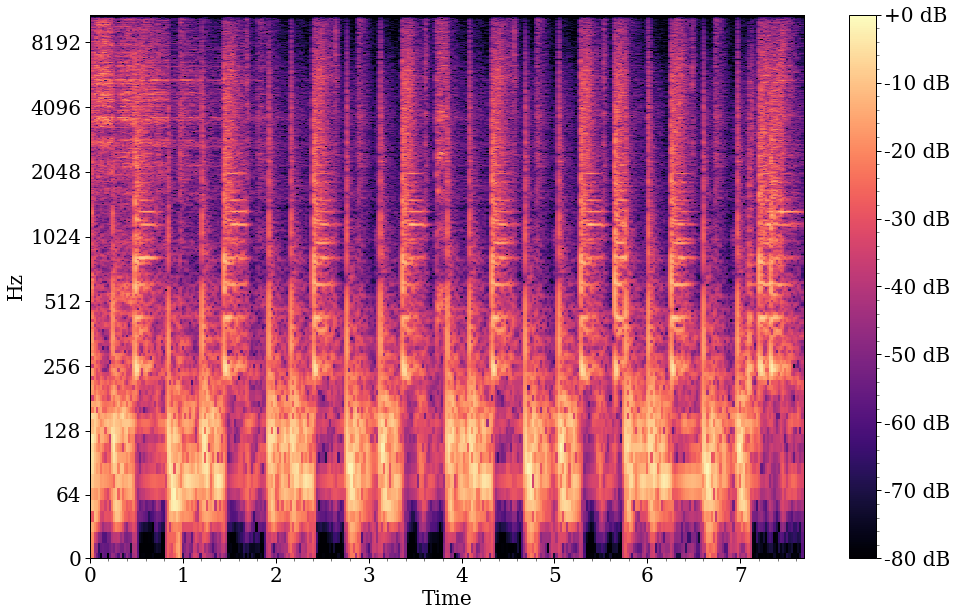

In [67]:
plot_spec(X)

In [68]:
### Qual a ideia de SVD?

In [69]:
@jax.jit
def svd_loss(Us, Vh, X):
    X_model = Us.dot(Vh)
    return jnp.mean((X - X_model) ** 2)

In [70]:
grad_fn = jax.grad(svd_loss, argnums=(0, 1))

In [77]:
k = 3
rows, cols = X.shape
Us = jnp.array(np.random.normal(size=(rows, k)))
Vh = jnp.array(np.random.normal(size=(k, cols)))

lr = 10
for i in range(5000):
    Us_prime, Vh_prime = grad_fn(Us, Vh, X)
    Us = Us - lr * Us_prime
    Vh = Vh - lr * Vh_prime
    if i % 100 == 0:
        print(i, svd_loss(Us, Vh, X))

0 12.726632
100 4.0011873
200 2.3763554
300 2.3552966
400 2.2953959
500 2.1735463
600 2.0733223
700 2.0329866
800 2.0180423
900 2.0102963
1000 2.0049107
1100 2.000715
1200 1.997368
1300 1.9947107
1400 1.9926237
1500 1.9910051
1600 1.9897621
1700 1.9888166
1800 1.9881017
1900 1.9875649
2000 1.9871616
2100 1.9868623
2200 1.986639
2300 1.9864731
2400 1.9863495
2500 1.9862577
2600 1.9861908
2700 1.9861401
2800 1.9861035
2900 1.9860756
3000 1.9860557
3100 1.9860407
3200 1.9860299
3300 1.9860209
3400 1.9860151
3500 1.9860103
3600 1.9860077
3700 1.9860047
3800 1.9860026
3900 1.9860016
4000 1.9860005
4100 1.9859998
4200 1.9859995
4300 1.9859989
4400 1.9859985
4500 1.9859985
4600 1.9859982
4700 1.9859983
4800 1.9859979
4900 1.9859982


In [78]:
def recover_from_one(Us, Vh, factor):
    right = Us[:, factor][:, np.newaxis]
    left = Vh[factor][np.newaxis]
    return right.dot(left)

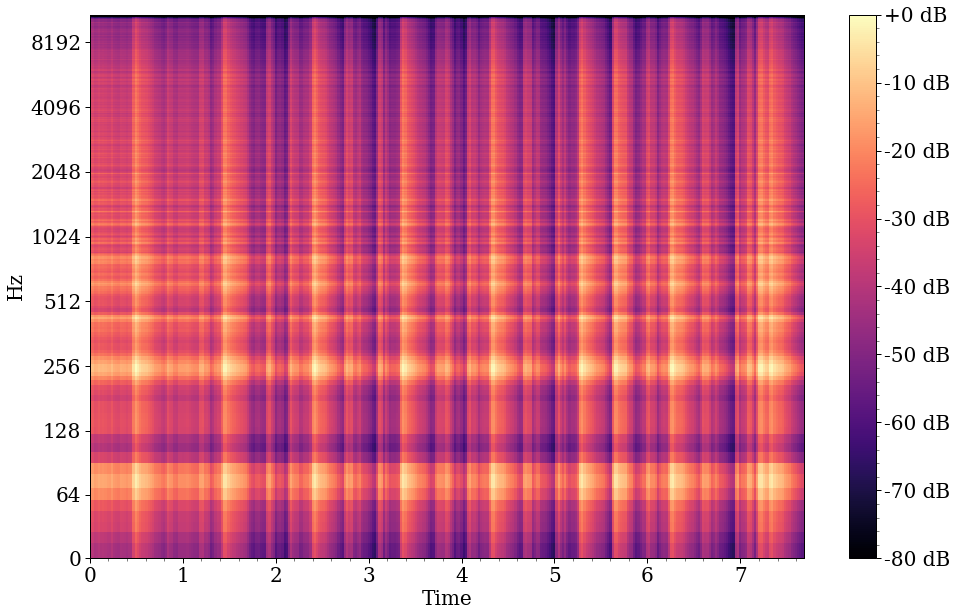

In [79]:
X_model = recover_from_one(Us, Vh, 0)
plot_spec(X_model)

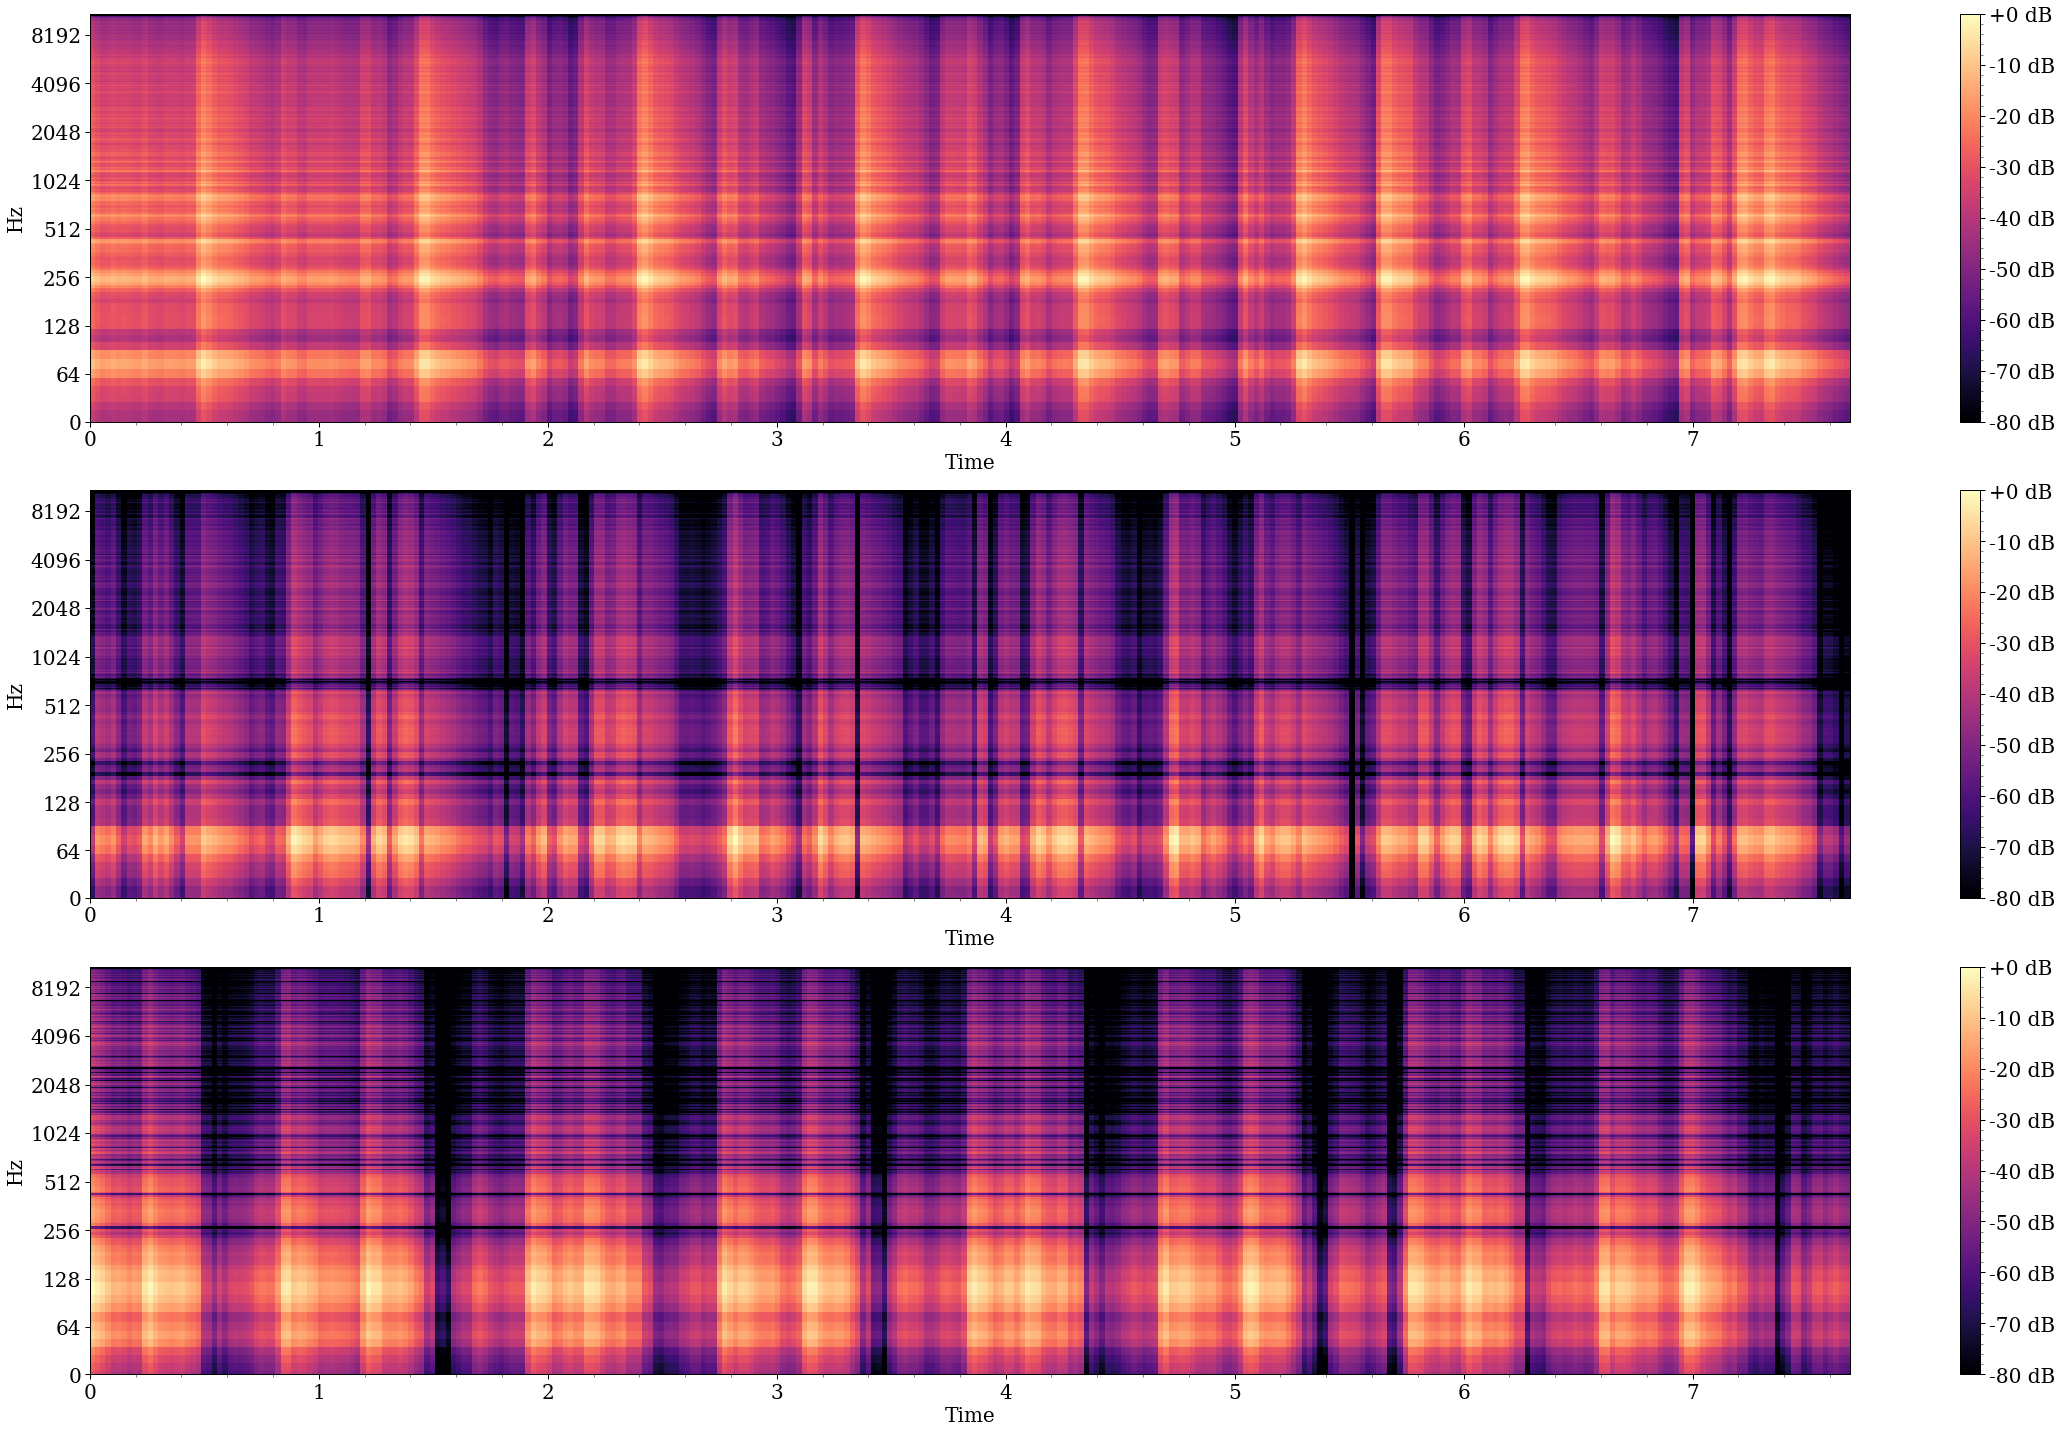

In [80]:
fig, axes = plt.subplots(k, 1, figsize=(32, 20))
for i in range(k):
    X_model = recover_from_one(Us, Vh, i)
    plot_spec(X_model, fig, axes[i])
fig.tight_layout()

In [86]:
X_model = recover_from_one(Us, Vh, 0)
S_model = X_model * np.exp(1j * A)
wav_model = librosa.istft(np.asarray(S_model))
ipd.Audio(wav_model, rate=sr)

In [87]:
X_model = recover_from_one(Us, Vh, 1)
S_model = X_model * np.exp(1j * A)
wav_model = librosa.istft(np.asarray(S_model))
ipd.Audio(wav_model, rate=sr)

In [88]:
X_model = recover_from_one(Us, Vh, 2)
S_model = X_model * np.exp(1j * A)
wav_model = librosa.istft(np.asarray(S_model))
ipd.Audio(wav_model, rate=sr)

In [90]:
k = 3
W = jnp.array(np.random.uniform(size=(rows, k)))
H = jnp.array(np.random.uniform(size=(k, cols)))

lr = 10
for i in range(5000):
    W = W * ((X @ H.T) / (((W @ H) @ H.T) + 0.0001))
    H = H * ((W.T @ X) / (((W.T @ W) @ H) + 0.0001))
    if i % 100 == 0:
        print(i, svd_loss(W, H, X))

0 4.6499557
100 1.9927531
200 1.9913135
300 1.9911313
400 1.9910825
500 1.9910543
600 1.9910425
700 1.9910374
800 1.9910357
900 1.9910351
1000 1.9910343
1100 1.9910334
1200 1.9910331
1300 1.9910326
1400 1.991031
1500 1.9910285
1600 1.9910258
1700 1.9910215
1800 1.9910195
1900 1.9910175
2000 1.9910161
2100 1.9910154
2200 1.9910145
2300 1.9910138
2400 1.991014
2500 1.9910138
2600 1.9910132
2700 1.991013
2800 1.9910127
2900 1.9910123
3000 1.9910111
3100 1.9910108
3200 1.9910101
3300 1.9910103
3400 1.9910101
3500 1.9910103
3600 1.9910103
3700 1.9910103
3800 1.9910103
3900 1.9910101
4000 1.9910101
4100 1.99101
4200 1.9910101
4300 1.9910101
4400 1.9910101
4500 1.9910097
4600 1.9910101
4700 1.99101
4800 1.9910101
4900 1.99101


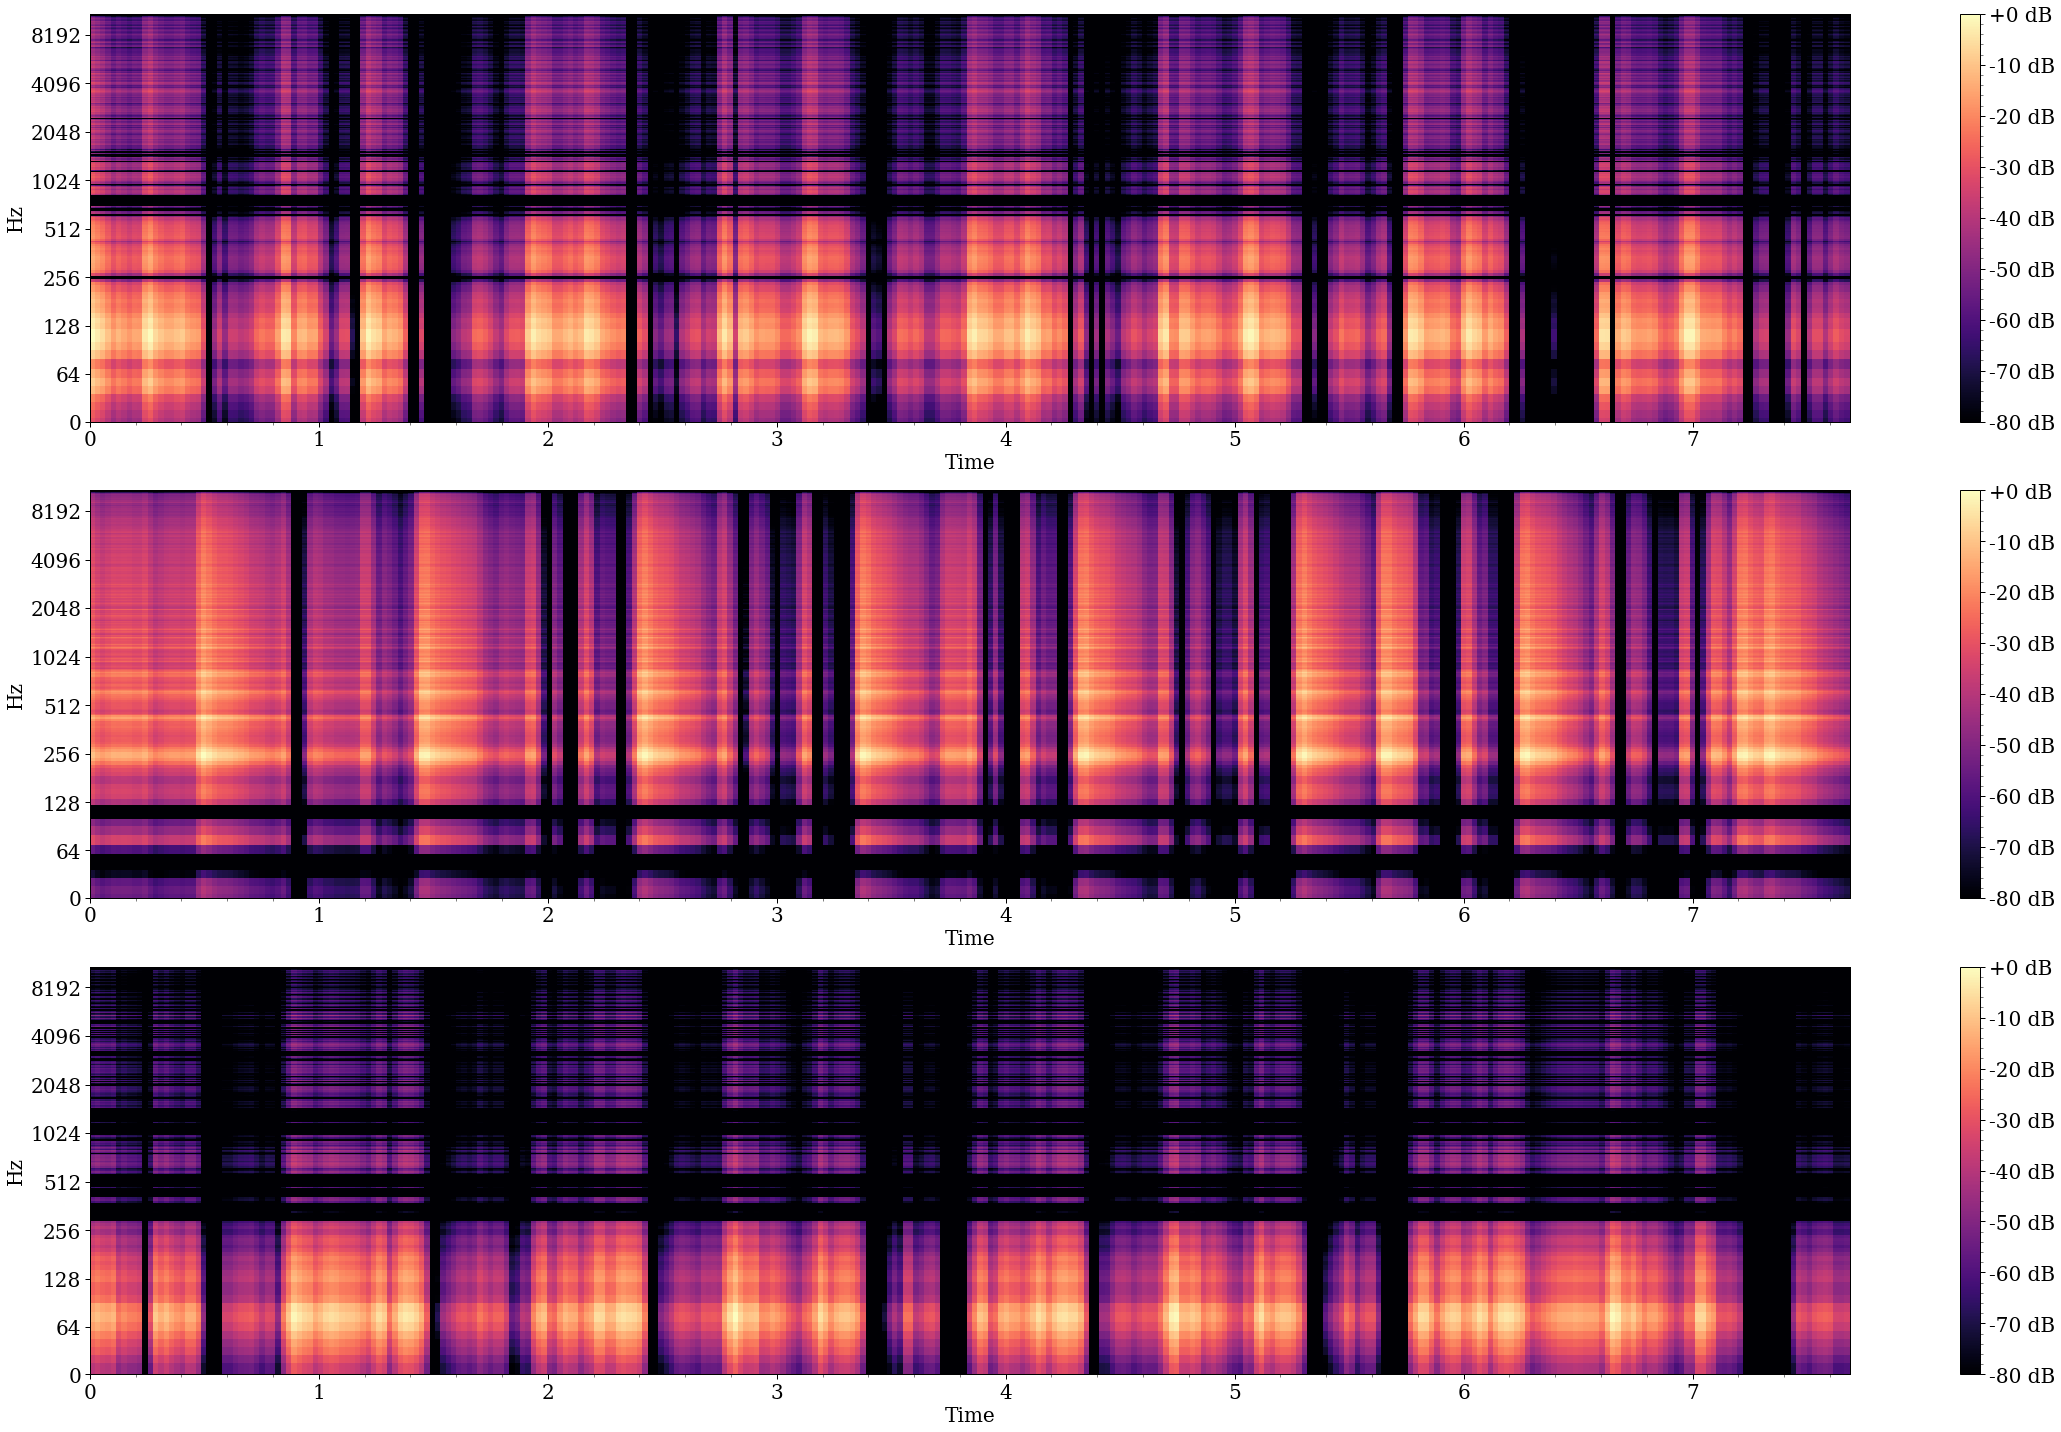

In [93]:
fig, axes = plt.subplots(k, 1, figsize=(32, 20))
for i in range(k):
    X_model = recover_from_one(W, H, i)
    plot_spec(X_model, fig, axes[i])
fig.tight_layout()

In [95]:
X_model = recover_from_one(W, H, 0)
S_model = X_model * np.exp(1j * A)
wav_model = librosa.istft(np.asarray(S_model))
ipd.Audio(wav_model, rate=sr)

In [96]:
X_model = recover_from_one(W, H, 1)
S_model = X_model * np.exp(1j * A)
wav_model = librosa.istft(np.asarray(S_model))
ipd.Audio(wav_model, rate=sr)

In [97]:
X_model = recover_from_one(W, H, 2)
S_model = X_model * np.exp(1j * A)
wav_model = librosa.istft(np.asarray(S_model))
ipd.Audio(wav_model, rate=sr)